In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
import time
# import umap.umap_ as umap
from sklearn.decomposition import PCA
from numpy import linalg as LA
from tqdm import tqdm
from IPython import display
%matplotlib inline
import pylab as pl

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()[:, pred_start:pred_end]
pro_s1d2 = pro_s1d2.X.toarray()[:, pred_start:pred_end]
pro_s1d3 = pro_s1d3.X.toarray()[:, pred_start:pred_end]
pro_s2d1 = pro_s2d1.X.toarray()[:, pred_start:pred_end]
pro_s2d4 = pro_s2d4.X.toarray()[:, pred_start:pred_end]
pro_s2d5 = pro_s2d5.X.toarray()[:, pred_start:pred_end]

pro_s3d1 = pro_s3d1.X.toarray()[:, pred_start:pred_end]
pro_s3d6 = pro_s3d6.X.toarray()[:, pred_start:pred_end]
pro_s3d7 = pro_s3d7.X.toarray()[:, pred_start:pred_end]

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()[:, pred_start:pred_end]
pro_s4d8 = pro_s4d8.X.toarray()[:, pred_start:pred_end]
pro_s4d9 = pro_s4d9.X.toarray()[:, pred_start:pred_end]

In [16]:
pro_s1d1 = np.concatenate([RNA_s1d1, pro_s1d1], axis= 1)
pro_s1d2 = np.concatenate([RNA_s1d2, pro_s1d2], axis= 1)
pro_s1d3 = np.concatenate([RNA_s1d3, pro_s1d3], axis= 1)
pro_s2d1 = np.concatenate([RNA_s2d1, pro_s2d1], axis= 1)
pro_s2d4 = np.concatenate([RNA_s2d4, pro_s2d4], axis= 1)
pro_s2d5 = np.concatenate([RNA_s2d5, pro_s2d5], axis= 1)

pro_s3d1 = np.concatenate([RNA_s3d1, pro_s3d1], axis= 1)
pro_s3d6 = np.concatenate([RNA_s3d6, pro_s3d6], axis= 1)
pro_s3d7 = np.concatenate([RNA_s3d7, pro_s3d7], axis= 1)

pro_s4d1 = np.concatenate([RNA_s4d1, pro_s4d1], axis= 1)
pro_s4d8 = np.concatenate([RNA_s4d8, pro_s4d8], axis= 1)
pro_s4d9 = np.concatenate([RNA_s4d9, pro_s4d9], axis= 1)

In [17]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 13954)


In [18]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [19]:
# batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
# batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
# batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [20]:
# train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
# train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

# val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
# val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

# test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
# test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [21]:
# train_input = train_input + val_input
# train_output = train_output + val_output

In [22]:
# train_input = np.concatenate(train_input, axis=0)
# val_input = np.concatenate(val_input, axis=0)
# test_input = np.concatenate(test_input, axis=0)

# train_output = np.concatenate(train_output, axis=0)
# val_output = np.concatenate(val_output, axis=0)
# test_output = np.concatenate(test_output, axis=0)

In [23]:
test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

test_input = np.concatenate(test_input, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [24]:
print(test_input.shape)
print(test_output.shape)

(1000, 13953)
(1000, 13954)


In [25]:
RNA_s1d1 = torch.from_numpy(RNA_s1d1)
RNA_s1d2 = torch.from_numpy(RNA_s1d2)
RNA_s1d3 = torch.from_numpy(RNA_s1d3)
RNA_s2d1 = torch.from_numpy(RNA_s2d1)
RNA_s2d4 = torch.from_numpy(RNA_s2d4)
RNA_s2d5 = torch.from_numpy(RNA_s2d5)
RNA_s3d1 = torch.from_numpy(RNA_s3d1)
RNA_s3d6 = torch.from_numpy(RNA_s3d6)
RNA_s3d7 = torch.from_numpy(RNA_s3d7)
RNA_s4d1 = torch.from_numpy(RNA_s4d1)
RNA_s4d8 = torch.from_numpy(RNA_s4d8)
RNA_s4d9 = torch.from_numpy(RNA_s4d9)

In [26]:
pro_s1d1 = torch.from_numpy(pro_s1d1)
pro_s1d2 = torch.from_numpy(pro_s1d2)
pro_s1d3 = torch.from_numpy(pro_s1d3)
pro_s2d1 = torch.from_numpy(pro_s2d1)
pro_s2d4 = torch.from_numpy(pro_s2d4)
pro_s2d5 = torch.from_numpy(pro_s2d5)
pro_s3d1 = torch.from_numpy(pro_s3d1)
pro_s3d6 = torch.from_numpy(pro_s3d6)
pro_s3d7 = torch.from_numpy(pro_s3d7)
pro_s4d1 = torch.from_numpy(pro_s4d1)
pro_s4d8 = torch.from_numpy(pro_s4d8)
pro_s4d9 = torch.from_numpy(pro_s4d9)

In [27]:
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [28]:
RNA_s1d1 = RNA_s1d1.float()
RNA_s1d2 = RNA_s1d2.float()
RNA_s1d3 = RNA_s1d3.float()
RNA_s2d1 = RNA_s2d1.float()
RNA_s2d4 = RNA_s2d4.float()
RNA_s2d5 = RNA_s2d5.float()
RNA_s3d1 = RNA_s3d1.float()
RNA_s3d6 = RNA_s3d6.float()
RNA_s3d7 = RNA_s3d7.float()
RNA_s4d1 = RNA_s4d1.float()
RNA_s4d8 = RNA_s4d8.float()
RNA_s4d9 = RNA_s4d9.float()

pro_s1d1 = pro_s1d1.float()
pro_s1d2 = pro_s1d2.float()
pro_s1d3 = pro_s1d3.float()
pro_s2d1 = pro_s2d1.float()
pro_s2d4 = pro_s2d4.float()
pro_s2d5 = pro_s2d5.float()
pro_s3d1 = pro_s3d1.float()
pro_s3d6 = pro_s3d6.float()
pro_s3d7 = pro_s3d7.float()
pro_s4d1 = pro_s4d1.float()
pro_s4d8 = pro_s4d8.float()
pro_s4d9 = pro_s4d9.float()

In [29]:
test_input = test_input.float()
test_output = test_output.float()

In [30]:
RNA_s1d1 = RNA_s1d1.to(device)
RNA_s1d2 = RNA_s1d2.to(device)
RNA_s1d3 = RNA_s1d3.to(device)
RNA_s2d1 = RNA_s2d1.to(device)
RNA_s2d4 = RNA_s2d4.to(device)
RNA_s2d5 = RNA_s2d5.to(device)
RNA_s3d1 = RNA_s3d1.to(device)
RNA_s3d6 = RNA_s3d6.to(device)
RNA_s3d7 = RNA_s3d7.to(device)
RNA_s4d1 = RNA_s4d1.to(device)
RNA_s4d8 = RNA_s4d8.to(device)
RNA_s4d9 = RNA_s4d9.to(device)

pro_s1d1 = pro_s1d1.to(device)
pro_s1d2 = pro_s1d2.to(device)
pro_s1d3 = pro_s1d3.to(device)
pro_s2d1 = pro_s2d1.to(device)
pro_s2d4 = pro_s2d4.to(device)
pro_s2d5 = pro_s2d5.to(device)
pro_s3d1 = pro_s3d1.to(device)
pro_s3d6 = pro_s3d6.to(device)
pro_s3d7 = pro_s3d7.to(device)
pro_s4d1 = pro_s4d1.to(device)
pro_s4d8 = pro_s4d8.to(device)
pro_s4d9 = pro_s4d9.to(device)

In [31]:
RNA_batches = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5, RNA_s3d1, RNA_s3d6, RNA_s3d7, RNA_s4d1, RNA_s4d8, RNA_s4d9]
pro_batches = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5, pro_s3d1, pro_s3d6, pro_s3d7, pro_s4d1, pro_s4d8, pro_s4d9]

In [32]:
test_input = test_input.to(device)
test_output = test_output.to(device)

In [33]:
input_feature = RNA_s1d1.shape[1]
# output_feature = pred_num

In [34]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, 50)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(50, input_feature+1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        emb = self.relu(x)
        
        output = self.linear5(emb)
        
        return output.float(), emb

In [35]:
RNA_dataset = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5, RNA_s3d1, RNA_s3d6, RNA_s3d7]
pro_dataset = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5, pro_s3d1, pro_s3d6, pro_s3d7]
emb_folder_names = ['s1d1_emb', 's1d2_emb', 's1d3_emb', 's2d1_emb', 's2d4_emb', 's2d5_emb', 's3d1_emb', 's3d6_emb', 's3d7_emb']

In [36]:
PATH = 'No_norm_model_RNA_pro'

In [37]:
train_ds_s1d1 = TensorDataset(RNA_dataset[0], pro_dataset[0])
train_dl_s1d1 = DataLoader(train_ds_s1d1, batch_size= batch_size, shuffle=True)

train_ds_s1d2 = TensorDataset(RNA_dataset[1], pro_dataset[1])
train_dl_s1d2 = DataLoader(train_ds_s1d2, batch_size= batch_size, shuffle=True)

train_ds_s1d3 = TensorDataset(RNA_dataset[2], pro_dataset[2])
train_dl_s1d3= DataLoader(train_ds_s1d3, batch_size= batch_size, shuffle=True)

train_ds_s2d1 = TensorDataset(RNA_dataset[3], pro_dataset[3])
train_dl_s2d1 = DataLoader(train_ds_s2d1, batch_size= batch_size, shuffle=True)

train_ds_s2d4 = TensorDataset(RNA_dataset[4], pro_dataset[4])
train_dl_s2d4 = DataLoader(train_ds_s2d4, batch_size= batch_size, shuffle=True)

train_ds_s2d5 = TensorDataset(RNA_dataset[5], pro_dataset[5])
train_dl_s2d5 = DataLoader(train_ds_s2d5, batch_size= batch_size, shuffle=True)

train_ds_s3d1 = TensorDataset(RNA_dataset[6], pro_dataset[6])
train_dl_s3d1 = DataLoader(train_ds_s3d1, batch_size= batch_size, shuffle=True)

train_ds_s3d6 = TensorDataset(RNA_dataset[7], pro_dataset[7])
train_dl_s3d6 = DataLoader(train_ds_s3d6, batch_size= batch_size, shuffle=True)

train_ds_s3d7 = TensorDataset(RNA_dataset[8], pro_dataset[8])
train_dl_s3d7 = DataLoader(train_ds_s3d7, batch_size= batch_size, shuffle=True)

In [38]:
train_dls = [train_dl_s1d1, train_dl_s1d2, train_dl_s1d3, train_dl_s2d1, train_dl_s2d4, train_dl_s2d5, train_dl_s3d1, train_dl_s3d6, train_dl_s3d7]

In [45]:
def fit(num_epochs, model, loss_fn, RNA, pro, train_batch_name, train_index):
    train_ds = TensorDataset(RNA, pro)
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)
    
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
        
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred, emb = model(x)
            loss_emb = loss_fn(pred[:, :-1], y[:, :-1])
            loss_pro = loss_fn(pred[:, -1], y[:, -1])
            loss = loss_pro + (loss_pro-loss_emb)**2
            # print('loss: ', loss, 'emb loss: ', loss_emb, 'pro loss:', loss_pro)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        if epoch % 1 == 0:
            model = model.eval()
                        
            losses_total_temp = []
            losses_encoder_temp = []
            losses_pro_temp = []
            
            for i in range(len(RNA_batches)):
                pred, emb = model(RNA_batches[i])
                # loss_total = torch.sqrt(loss_fn(pred, pro_batches[i])).cpu().detach().numpy()
                loss_encoder = torch.sqrt(loss_fn(pred[:, :-1], pro_batches[i][:, :-1])).cpu().detach().numpy()
                loss_pro = torch.sqrt(loss_fn(pred[:, -1], pro_batches[i][:, -1])).cpu().detach().numpy()
                loss_total = loss_pro + loss_encoder
                
                losses_total[train_index, i, epoch] = loss_total
                losses_encoder[train_index, i, epoch] = loss_encoder
                losses_pro[train_index, i, epoch] = loss_pro
                
                losses_total_temp.append(loss_total)
                losses_encoder_temp.append(loss_encoder)
                losses_pro_temp.append(loss_pro)
                
            loss_emb_plot.append(losses_encoder_temp)
            loss_pro_plot.append(losses_pro_temp)
            
            cal_pro_test_loss = ((losses_pro_temp[-3]**2*RNA_batches[-3].shape[0] + losses_pro_temp[-2]**2*RNA_batches[-2].shape[0] + losses_pro_temp[-1]**2*RNA_batches[-1].shape[0])/(RNA_batches[-3].shape[0]+RNA_batches[-2].shape[0]+RNA_batches[-1].shape[0]))**0.5
            
            if epoch == 799:
#                 print('Epoch: ', epoch)
#                 print('Total loss:', 's1d1: ', losses_total_temp[0], 's1d2: ', losses_total_temp[1], 's1d3: ', losses_total_temp[2], 's2d1:', losses_total_temp[3], 's2d4:',
#                     losses_total_temp[4], 's2d5:', losses_total_temp[5], 's3d1:', losses_total_temp[6], 's3d6:', losses_total_temp[7], 's3d7:', losses_total_temp[8], 's4d1:', losses_total_temp[9], 's4d8:', 
#                       losses_total_temp[10], 's4d9:', losses_total_temp[11])

#                 print('Emb loss:', 's1d1: ', losses_encoder_temp[0], 's1d2: ', losses_encoder_temp[1], 's1d3: ', losses_encoder_temp[2], 's2d1:', losses_encoder_temp[3], 's2d4:',
#                     losses_encoder_temp[4], 's2d5:', losses_encoder_temp[5], 's3d1:', losses_encoder_temp[6], 's3d6:', losses_encoder_temp[7], 's3d7:', losses_encoder_temp[8], 's4d1:', losses_encoder_temp[9], 's4d8:', 
#                       losses_encoder_temp[10], 's4d9:', losses_encoder_temp[11])
                
#                 print('Protein loss:', 's1d1: ', losses_pro_temp[0], 's1d2: ', losses_pro_temp[1], 's1d3: ', losses_pro_temp[2], 's2d1:', losses_pro_temp[3], 's2d4:',
#                     losses_pro_temp[4], 's2d5:', losses_pro_temp[5], 's3d1:', losses_pro_temp[6], 's3d6:', losses_pro_temp[7], 's3d7:', losses_pro_temp[8], 's4d1:', losses_pro_temp[9], 's4d8:', 
#                       losses_pro_temp[10], 's4d9:', losses_pro_temp[11], 'test:', cal_pro_test_loss)
                
                # plt.scatter(losses_encoder_temp, losses_pro_temp)
                # plt.title('Epoch ' + str(epoch))
                # plt.xlabel('Embedding loss')
                # plt.ylabel('Protein prediction loss')
                # display.clear_output(wait=True)
                # display.display(plt.gcf())
                # time.sleep(1.0)
                # plt.show()
                
                figure, ax = plt.subplots(2, 6, figsize = (20, 8))
                figure.tight_layout()
                plt.subplots_adjust(wspace = 0.3, hspace = 0.4)
                ax = ax.flatten()
                for i in range(12):
                    temp = []
                    for j in range(len(loss_emb_plot)):
                        temp.append(loss_pro_plot[j][i]/loss_emb_plot[j][i])
                    ax[i].scatter(list(range(len(loss_pro_plot))), temp, c='blue', s = 30, alpha=1, label = 'pro/emb ratio')
                    ax[i].scatter(list(range(len(loss_pro_plot))), [ele[i] for ele in loss_pro_plot], c='red', s = 30, alpha=1, label = 'pro loss')
                    ax[i].scatter(list(range(len(loss_pro_plot))), [ele[i] for ele in loss_emb_plot], c='green', s = 30, alpha=1, label = 'emb loss')
                    ax[i].legend(loc = 'upper right')
                    # ax[i].plot([0, 1], [0, 1], 'k-')
                    ax[i].set_title('E: ' + str(epoch) + ' pro/emb: ' + str(loss_pro_plot[epoch][i]/loss_emb_plot[epoch][i]) + '\n' + 'pro loss: ' + str(loss_pro_plot[epoch][i]) + '\n' + 'emb loss:' + str(loss_emb_plot[epoch][i]))
                    ax[i].set_xlabel('Embedding loss')
                    ax[i].set_ylabel('Protein prediction loss')
                plt.show()
                # display.clear_output(wait=True)
                # display.display(pl.gcf())
                # time.sleep(1.0)
                
        batches = ['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7', 's4d1', 's4d8', 's4d9']
        
        # batches_emb_pred = [s1d1_emb.cpu().detach().numpy(), s1d2_emb.cpu().detach().numpy(), s1d3_emb.cpu().detach().numpy(), s2d1_emb.cpu().detach().numpy(), s2d4_emb.cpu().detach().numpy(), 
        #         s2d5_emb.cpu().detach().numpy(), s3d1_emb.cpu().detach().numpy(), s3d6_emb.cpu().detach().numpy(), s3d7_emb.cpu().detach().numpy(), s4d1_emb.cpu().detach().numpy(), 
        #         s4d8_emb.cpu().detach().numpy(), s4d9_emb.cpu().detach().numpy()]
        
#         if epoch == 1999:
#             path = train_batch_name
#             try:
#                 os.mkdir(path)
#             except OSError as error:
#                 print(error)  
#             for i in range(len(batches)):
#                 filehandler = open(train_batch_name + '/' + batches[i] + '.pickle', "wb")
#                 pickle.dump(batches_emb_pred[i], filehandler)
#                 filehandler.close()
                
#         batches_pred = [s1d1_pred.cpu().detach().numpy(), s1d2_pred.cpu().detach().numpy(), s1d3_pred.cpu().detach().numpy(), s2d1_pred.cpu().detach().numpy(), s2d4_pred.cpu().detach().numpy(), 
#                         s2d5_pred.cpu().detach().numpy(), s3d1_pred.cpu().detach().numpy(), s3d6_pred.cpu().detach().numpy(), s3d7_pred.cpu().detach().numpy(), s4d1_pred.cpu().detach().numpy(), 
#                         s4d8_pred.cpu().detach().numpy(), s4d9_pred.cpu().detach().numpy()]
        
#         if epoch == 1999:
#             path = train_batch_name
#             try:
#                 os.mkdir(path[:-3]+'pred')
#             except OSError as error:
#                 print(error)  
#             for i in range(len(batches)):
#                 filehandler = open(train_batch_name[:-3] + 'pred' + '/' + batches[i] + '.pickle', "wb")
#                 pickle.dump(batches_pred[i], filehandler)
#                 filehandler.close()
                

                
#         if epoch % 1000 == 0:
#             figure, ax = plt.subplots(1, 12, figsize = (30, 3))
#             for i in range(1):
#                 ax[0].scatter(pro_s1d1.cpu().detach().numpy()[:, -1], s1d1_pred.cpu().detach().numpy()[:, -1], c='blue', s = 30, alpha=0.05)
#                 ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
#                 ax[0].set_title('s1d1 result')
#                 ax[0].set_xlabel('true')
#                 ax[0].set_ylabel('pred')

#                 ax[1].scatter(pro_s1d2.cpu().detach().numpy()[:, -1], s1d2_pred.cpu().detach().numpy()[:, -1], c='blue', s = 30, alpha=0.05)
#                 ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
#                 ax[1].set_title('s1d2 result')
#                 ax[1].set_xlabel('true')
#                 ax[1].set_ylabel('pred')

#                 ax[2].scatter(pro_s1d3.cpu().detach().numpy()[:, -1], s1d3_pred.cpu().detach().numpy()[:, -1], c='blue', s = 30, alpha=0.05)
#                 ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
#                 ax[2].set_title('s1d3 result')
#                 ax[2].set_xlabel('true')
#                 ax[2].set_ylabel('pred')
                
#                 ax[3].scatter(pro_s2d1.cpu().detach().numpy()[:, -1], s2d1_pred.cpu().detach().numpy()[:, -1], c='red', s = 30, alpha=0.05)
#                 ax[3].plot([-1.5, 3], [-1.5, 3], 'k-')
#                 ax[3].set_title('s2d1 result')
#                 ax[3].set_xlabel('true')
#                 ax[3].set_ylabel('pred')

#                 ax[4].scatter(pro_s2d4.cpu().detach().numpy()[:, -1], s2d4_pred.cpu().detach().numpy()[:, -1], c='red', s = 30, alpha=0.05)
#                 ax[4].plot([-1.5, 3], [-1.5, 3], 'k-')
#                 ax[4].set_title('s2d4 result')
#                 ax[4].set_xlabel('true')
#                 ax[4].set_ylabel('pred')

#                 ax[5].scatter(pro_s2d5.cpu().detach().numpy()[:, -1], s2d5_pred.cpu().detach().numpy()[:, -1], c='red', s = 30, alpha=0.05)
#                 ax[5].plot([-1.5, 3], [-1.5, 3], 'k-')
#                 ax[5].set_title('s2d5 result')
#                 ax[5].set_xlabel('true')
#                 ax[5].set_ylabel('pred')
                
#                 ax[6].scatter(pro_s3d1.cpu().detach().numpy()[:, -1], s3d1_pred.cpu().detach().numpy()[:, -1], c='orange', s = 30, alpha=0.05)
#                 ax[6].plot([-1.5, 3], [-1.5, 3], 'k-')
#                 ax[6].set_title('s3d1 result')
#                 ax[6].set_xlabel('true')
#                 ax[6].set_ylabel('pred')

#                 ax[7].scatter(pro_s3d6.cpu().detach().numpy()[:, -1], s3d6_pred.cpu().detach().numpy()[:, -1], c='orange', s = 30, alpha=0.05)
#                 ax[7].plot([-1.5, 3], [-1.5, 3], 'k-')
#                 ax[7].set_title('s3d6 result')
#                 ax[7].set_xlabel('true')
#                 ax[7].set_ylabel('pred')

#                 ax[8].scatter(pro_s3d7.cpu().detach().numpy()[:, -1], s3d7_pred.cpu().detach().numpy()[:, -1], c='orange', s = 30, alpha=0.05)
#                 ax[8].plot([-1.5, 3], [-1.5, 3], 'k-')
#                 ax[8].set_title('s3d7 result')
#                 ax[8].set_xlabel('true')
#                 ax[8].set_ylabel('pred')
                
#                 ax[9].scatter(pro_s4d1.cpu().detach().numpy()[:, -1], s4d1_pred.cpu().detach().numpy()[:, -1], c='green', s = 30, alpha=0.05)
#                 ax[9].plot([-1.5, 3], [-1.5, 3], 'k-')
#                 ax[9].set_title('s4d1 result')
#                 ax[9].set_xlabel('true')
#                 ax[9].set_ylabel('pred')

#                 ax[10].scatter(pro_s4d8.cpu().detach().numpy()[:, -1], s4d8_pred.cpu().detach().numpy()[:, -1], c='green', s = 30, alpha=0.05)
#                 ax[10].plot([-1.5, 3], [-1.5, 3], 'k-')
#                 ax[10].set_title('s4d8 result')
#                 ax[10].set_xlabel('true')
#                 ax[10].set_ylabel('pred')

#                 ax[11].scatter(pro_s4d9.cpu().detach().numpy()[:, -1], s4d9_pred.cpu().detach().numpy()[:, -1], c='green', s = 30, alpha=0.05)
#                 ax[11].plot([-1.5, 3], [-1.5, 3], 'k-')
#                 ax[11].set_title('s4d9 result')
#                 ax[11].set_xlabel('true')
#                 ax[11].set_ylabel('pred')
            
#             plt.show()
    return

In [46]:
num_epochs = 800
losses_total = np.zeros((9, 12, num_epochs))
losses_encoder = np.zeros((9,12, num_epochs))
losses_pro = np.zeros((9, 12, num_epochs))


Training on dataset s1d1_emb


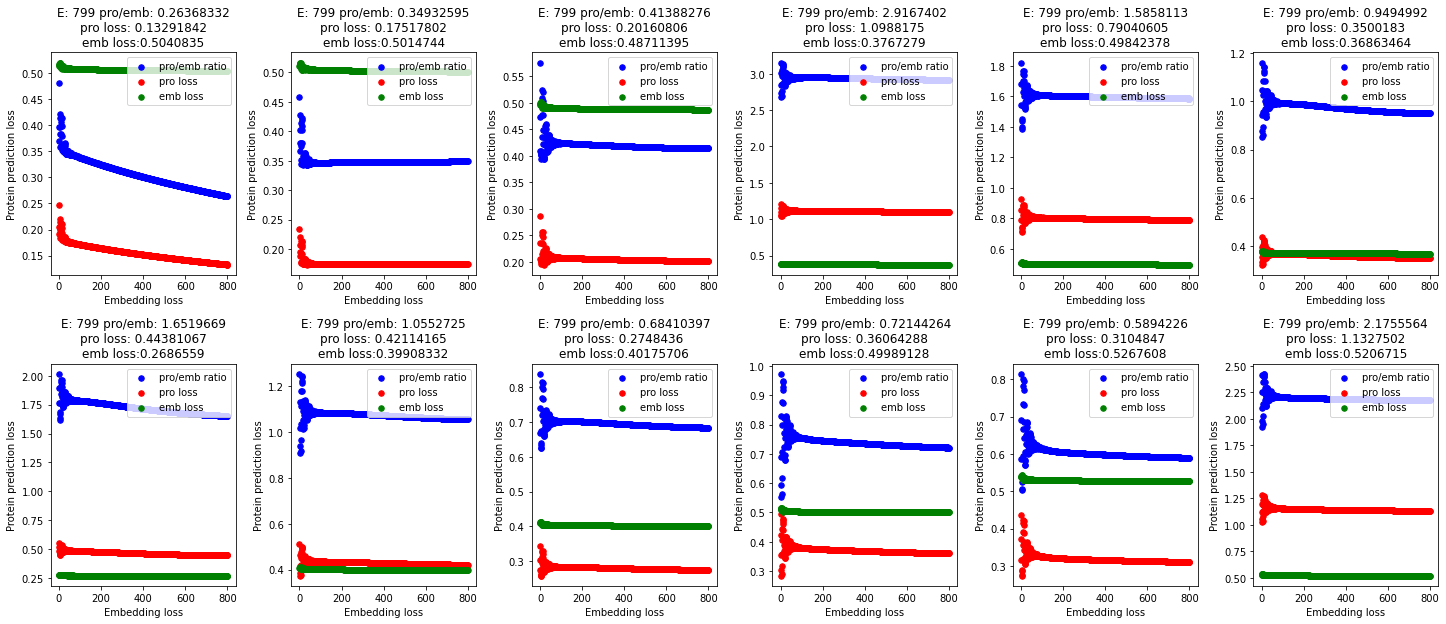


Training on dataset s1d2_emb


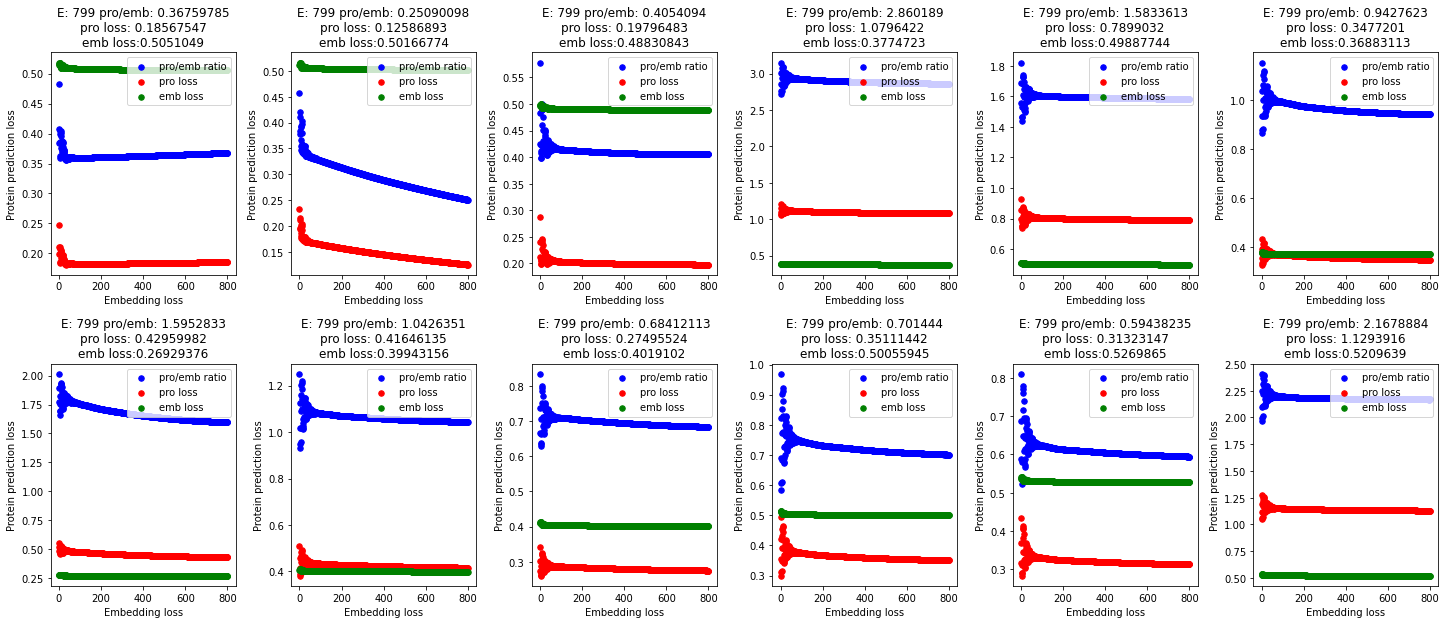


Training on dataset s1d3_emb


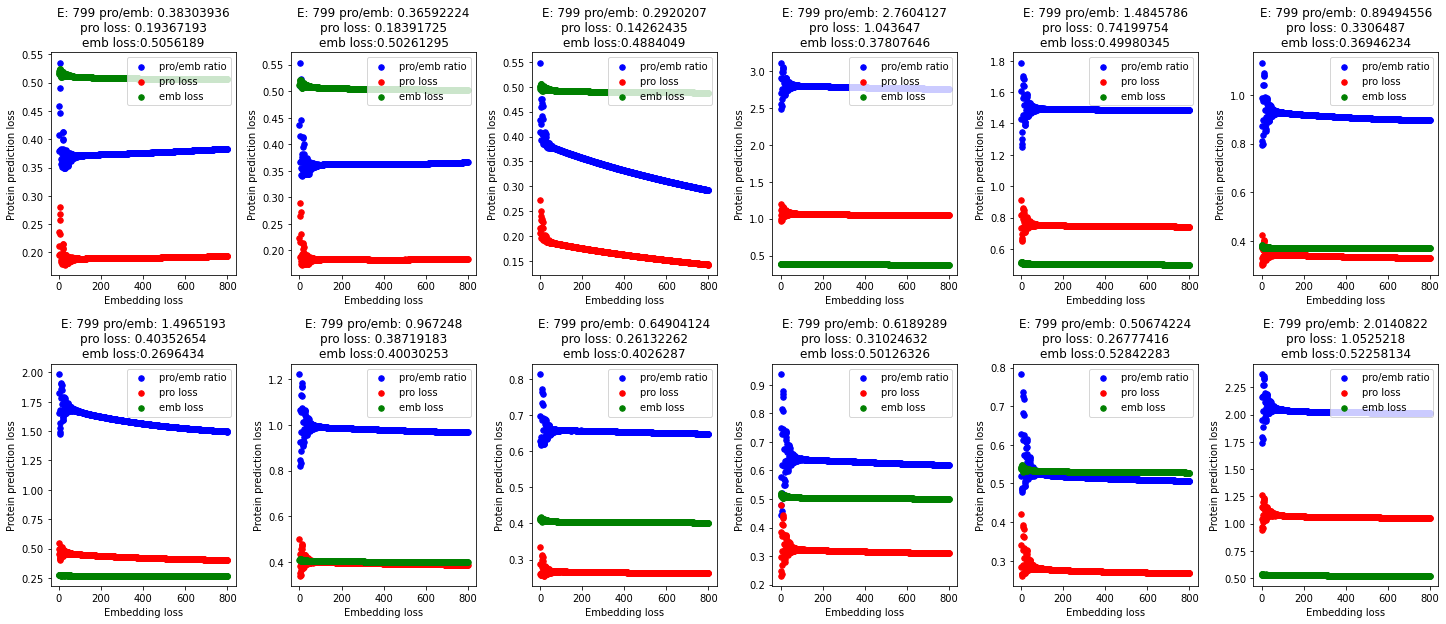


Training on dataset s2d1_emb


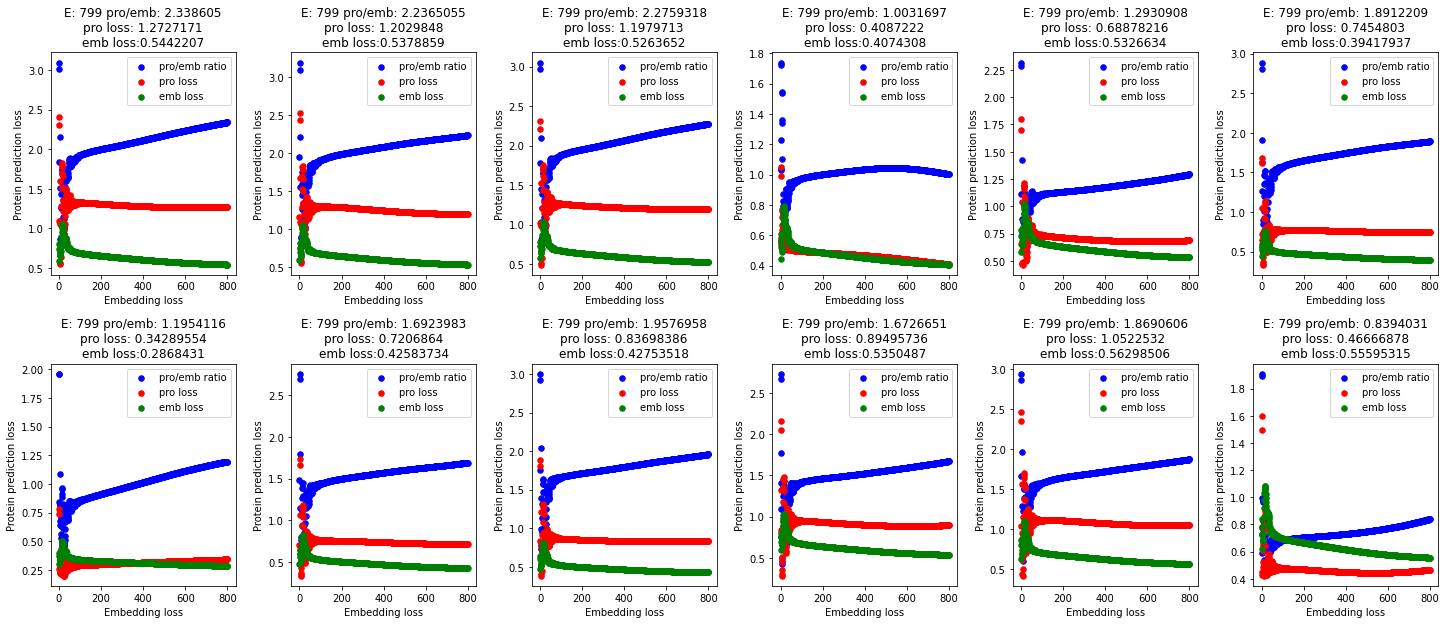


Training on dataset s2d4_emb


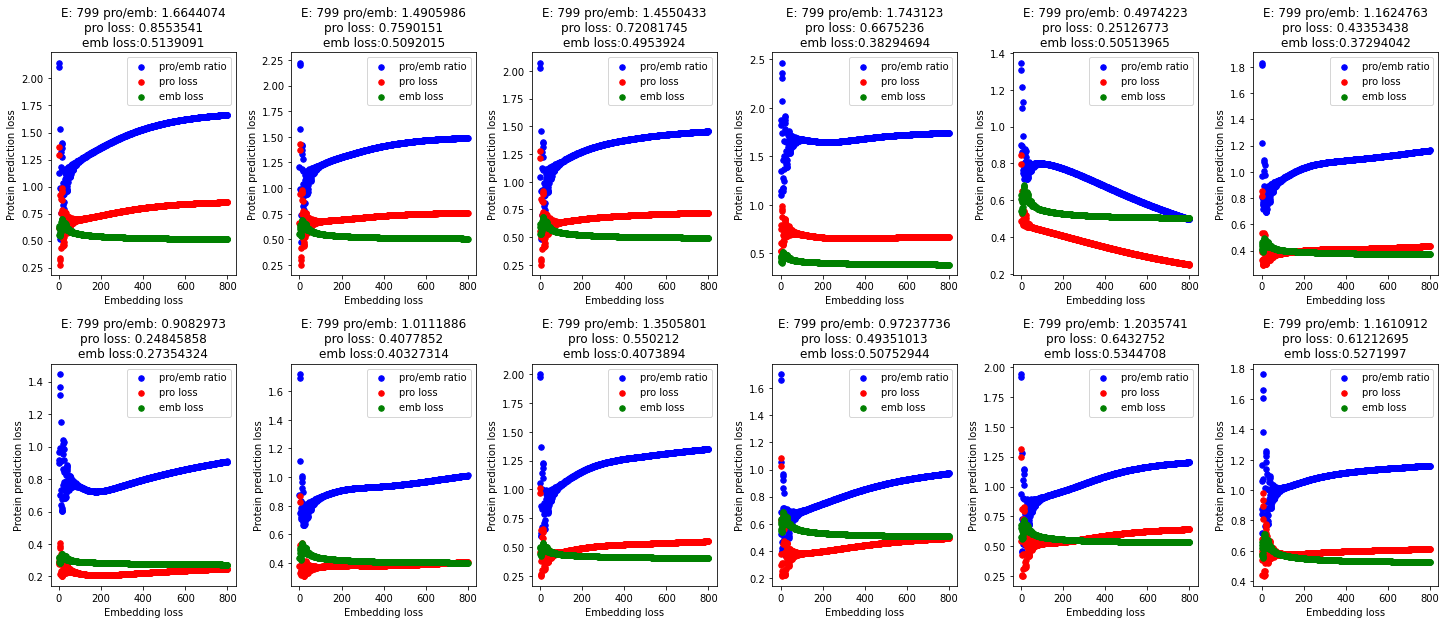


Training on dataset s2d5_emb


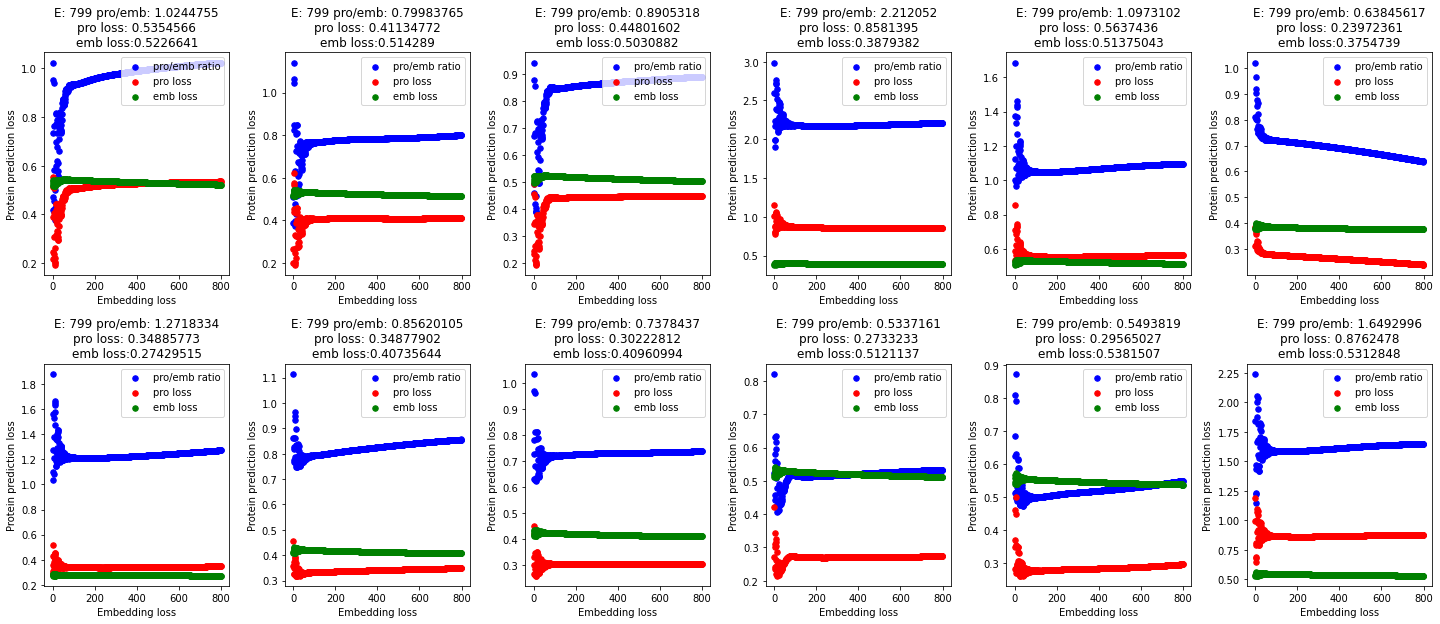


Training on dataset s3d1_emb


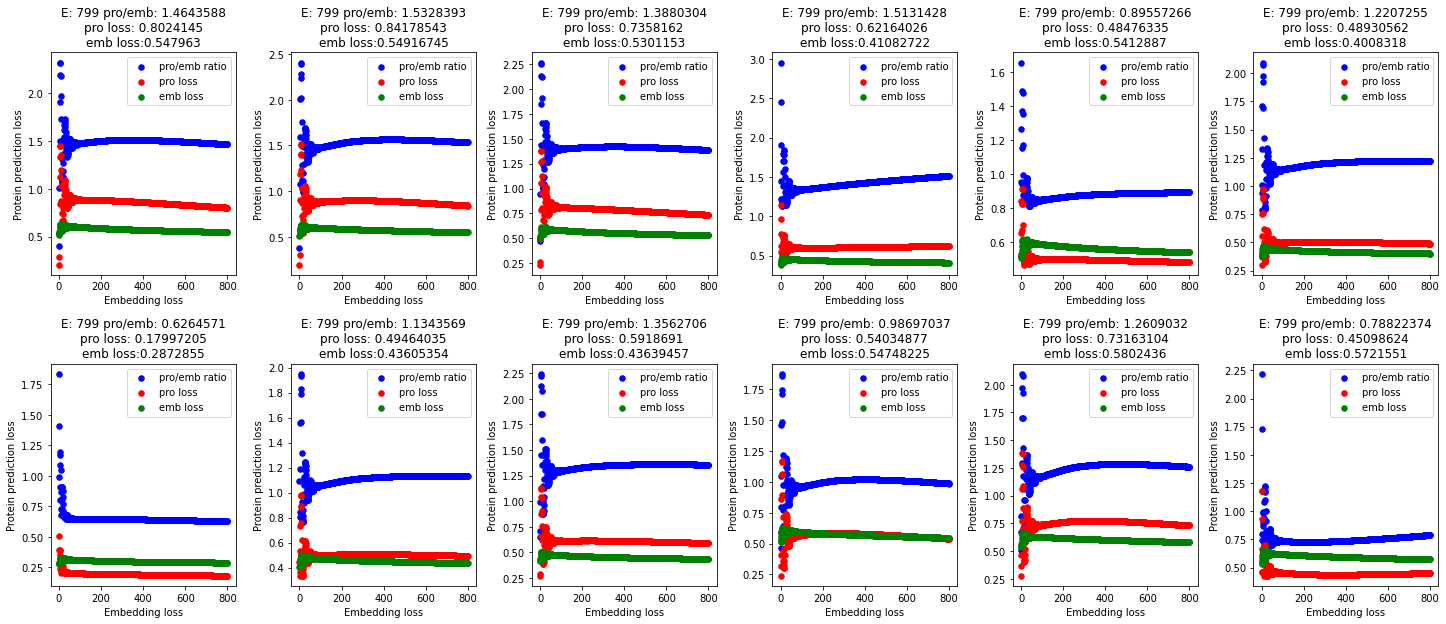


Training on dataset s3d6_emb


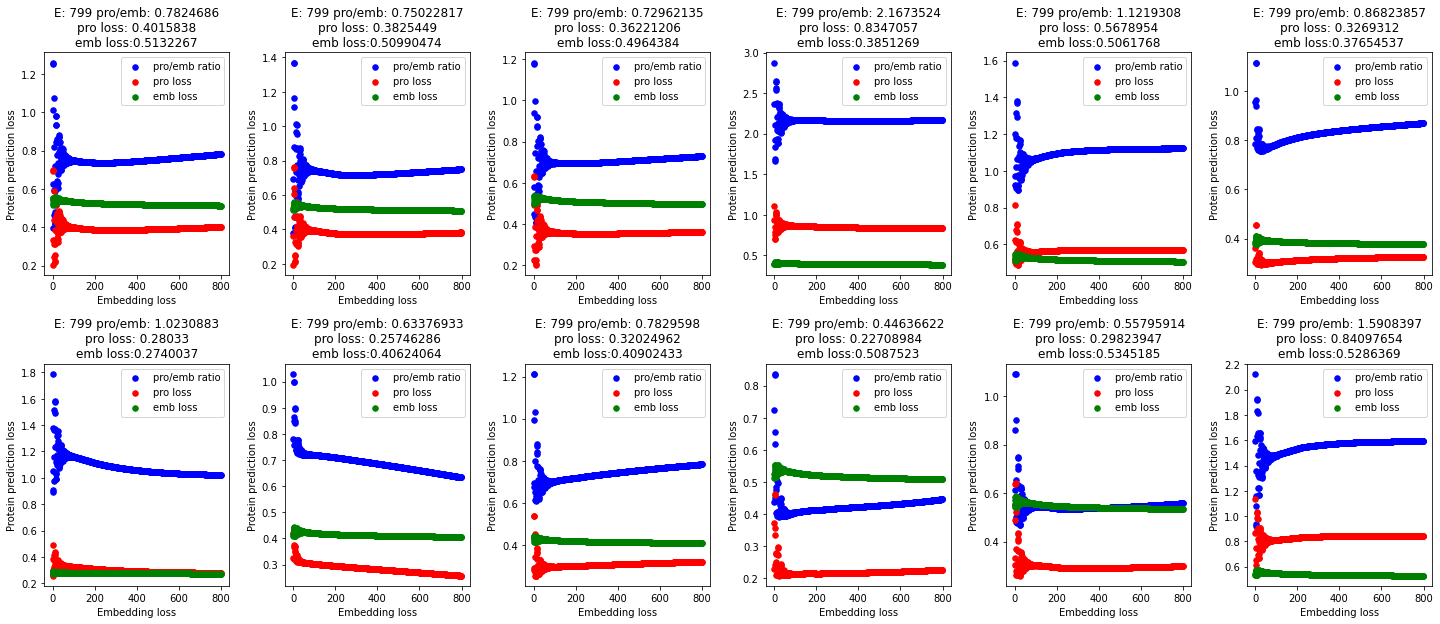


Training on dataset s3d7_emb


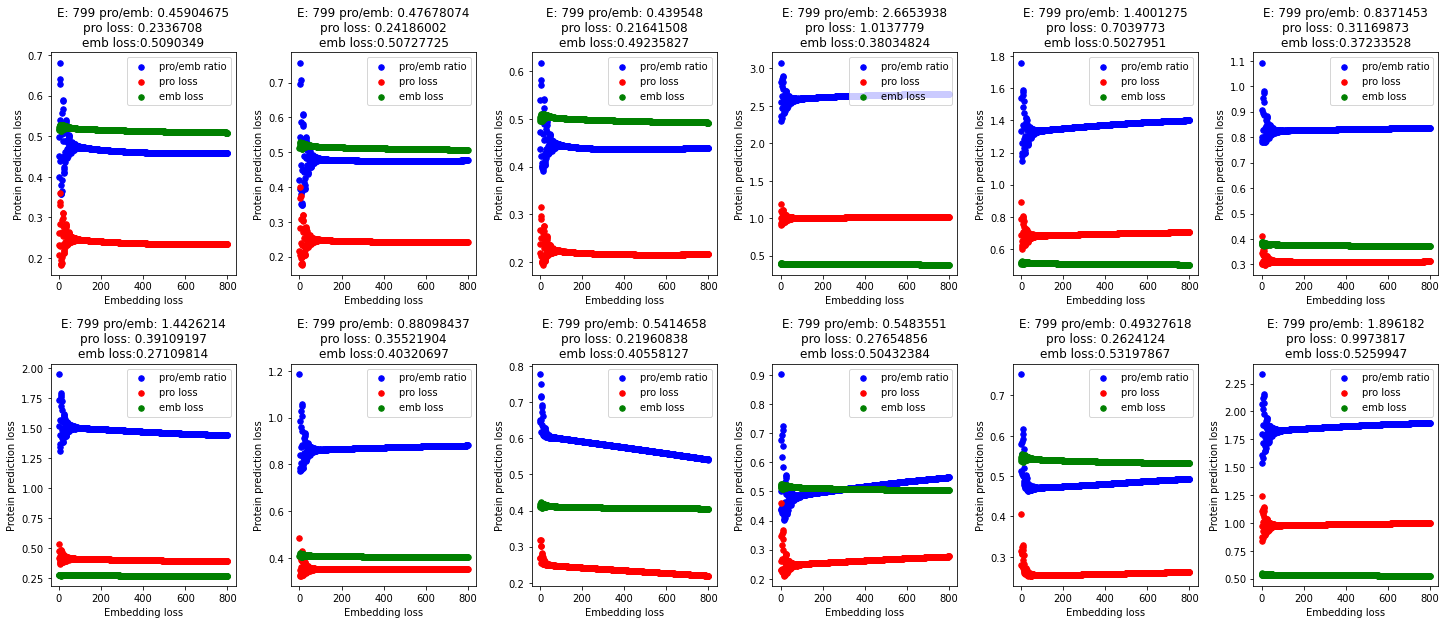

In [47]:
for i in range(len(RNA_dataset)):
    print()
    print('Training on dataset ' + emb_folder_names[i])
    learning_rate = 0.001
    latent_dim = 50
    loss_fn = F.mse_loss
    batch_size = 50000
    
    loss_emb_plot = []
    loss_pro_plot = []
    
    def seed_everything(seed=1234):
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

    seed_everything()

    model = Autoencoder()
    # model.load_state_dict(torch.load('Batch_feature_norm_model'))
    model = model.to(device)
    opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    fit(num_epochs, model, loss_fn, RNA_dataset[i], pro_dataset[i], emb_folder_names[i], i)